## Install Libraries

In [1]:
!pip install rouge-score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=aa6b9435dfe5de5d3970839702020c6ca2bd4c79e0829dc2208a58703f785dbd
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


## Introduction

We have a dataset of news articles from BBC along with summaries written for those articles. Our goal will be to train an Transformer with a subset of the dataset and then evaluate how the model performs on the test set. To manage processing time, we will be using about 30% of the overall dataset ater dropping some of the rows with much longer text.

1. Perform preliminary data analysis
2. Drop rows where word count exceeds 400. We do this to ensure our model can tokenize with extra padding and still stay under the max length limit of 512.
3. Take a random sample of 30% of the data.
4. Tokenize both input and target text features
5. Apply train test split. 80/20
6. Prepare data loaders including attention mask, padding and truncation
7. Train BART-base model using an optimizer
8. Evaluate the model on the test set
9. Review results using ROGUE scoring

During training we will also implement Gradient Accumulation. Gradient Accumulation is a technique that simulates a larger batch size by accumulating gradients from multiple small batches before performing a weight update. This technique can be helpful in scenarios where the available memory is limited, and the batch size that can fit in memory is small.

## Importing necessary libraries

In [2]:
import nltk 
import seaborn as sns 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
import os

import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import TensorDataset, DataLoader
from transformers import BartTokenizer, BartForConditionalGeneration, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import pandas as pd
from rouge_score import rouge_scorer
from torch.cuda.amp import autocast, GradScaler
from torch.nn.utils import clip_grad_norm_

## Reading the data

In [3]:
paths = os.listdir('../input/bbc-news-summary/BBC News Summary/News Articles')
articles_path = '../input/bbc-news-summary/BBC News Summary/News Articles/'
summaries_path = '../input/bbc-news-summary/BBC News Summary/Summaries/'

## Storing in a dataframe

In [4]:
articles = []
summaries = []
file_arr = []

for path in paths:
    files = os.listdir(articles_path + path)
    for file in files:
        article_file_path = articles_path + path + '/' + file
        summary_file_path = summaries_path + path + '/' + file
        try:
            with open (article_file_path,'r') as f:
                articles.append('.'.join([line.rstrip() for line in f.readlines()]))
            with open (summary_file_path,'r') as f:
                summaries.append('.'.join([line.rstrip() for line in f.readlines()]))
            file_arr.append(path + '/' + file)
        except:
            pass

In [5]:
df = pd.DataFrame({'path':file_arr,'article': articles,'summary':summaries})
df.head(2)

,path,article,summary
0,politics/361.txt,Budget to set scene for election..Gordon Brown...,- Increase in the stamp duty threshold from £6...
1,politics/245.txt,Army chiefs in regiments decision..Military ch...,"""They are very much not for the good and will ..."


## Data Analysis and EDA

Adding word counts  to both article and the summary to get a better understanding of the text size

In [6]:
# Function to count the number of words in a text
def count_words(text):
    return len(text.split())

df['wordcnt_article'] = df['article'].apply(count_words)
df['wordcnt_summary'] = df['summary'].apply(count_words)

In [7]:
df.head(2)

,path,article,summary,wordcnt_article,wordcnt_summary
0,politics/361.txt,Budget to set scene for election..Gordon Brown...,- Increase in the stamp duty threshold from £6...,532,192
1,politics/245.txt,Army chiefs in regiments decision..Military ch...,"""They are very much not for the good and will ...",496,266


In [8]:
df.describe()

,wordcnt_article,wordcnt_summary
count,2224.000000,2224.000000
mean,379.286871,165.151529
std,235.081995,108.678038
min,87.000000,38.000000
25%,242.000000,103.000000
50%,327.000000,142.000000
75%,465.250000,202.000000
max,4377.000000,2073.000000


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2224 entries, 0 to 2223
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   path             2224 non-null   object
 1   article          2224 non-null   object
 2   summary          2224 non-null   object
 3   wordcnt_article  2224 non-null   int64 
 4   wordcnt_summary  2224 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 87.0+ KB


Looking at the word count distributon, we see there are some outliers. Our goal will be to stay within our model's allowed max_length so we will choose the records where article word count is less than 400.

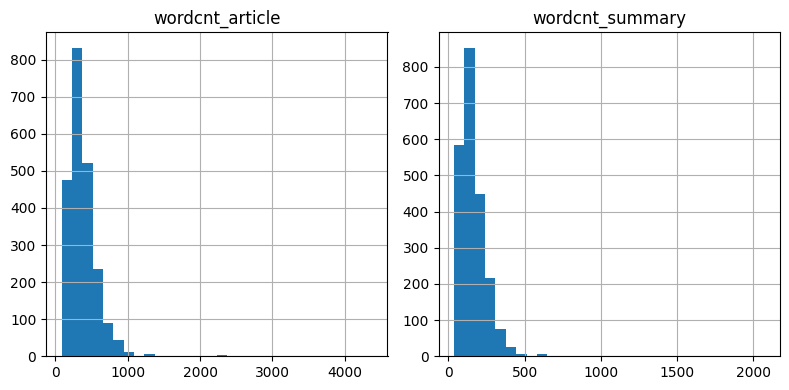

In [10]:
numerical_columns = df.select_dtypes(include=['int64'])

# Create histograms for all numerical columns
numerical_columns.hist(bins=30, figsize=(8, 4))
plt.tight_layout()

plt.show()

In [11]:
filtered_df = df[df['wordcnt_article'] < 400]
filtered_df.describe()

,wordcnt_article,wordcnt_summary
count,1429.000000,1429.000000
mean,265.725682,115.603219
std,71.062142,32.977902
min,87.000000,38.000000
25%,213.000000,91.000000
50%,263.000000,114.000000
75%,319.000000,139.000000
max,399.000000,211.000000


Looking at the distributions again

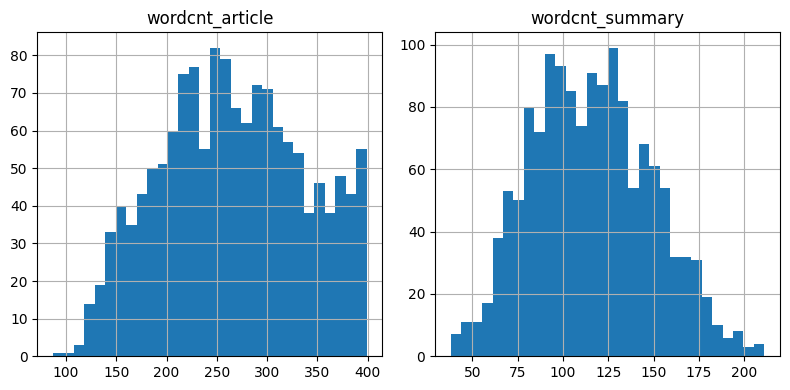

In [12]:
numerical_columns = filtered_df.select_dtypes(include=['int64'])

# Create histograms for all numerical columns
numerical_columns.hist(bins=30, figsize=(8, 4))
plt.tight_layout()

plt.show()

In [13]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1429 entries, 7 to 2223
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   path             1429 non-null   object
 1   article          1429 non-null   object
 2   summary          1429 non-null   object
 3   wordcnt_article  1429 non-null   int64 
 4   wordcnt_summary  1429 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 67.0+ KB


## Preprocessing

In [14]:
# Drop columns from the DataFrame
filtered_df = filtered_df.drop(['wordcnt_article', 'wordcnt_summary', 'path'], axis=1)

filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1429 entries, 7 to 2223
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   article  1429 non-null   object
 1   summary  1429 non-null   object
dtypes: object(2)
memory usage: 33.5+ KB


To optimize processing time, we will sample 30% of the data to see what we can achieve.

In [15]:
# Calculate the number of rows to sample (30% of the original data)
sample_size = int(0.3 * len(filtered_df))

# Sample 30% of the data
sampled_df = filtered_df.sample(n=sample_size, random_state=42)  # You can choose any random_state value for reproducibility
sampled_df.head(3)

,article,summary
296,Talks aim to avert pension strike..Talks aimed...,The five unions meeting Mr Prescott want the g...
1906,Fannie Mae 'should restate books'..US mortgage...,US mortgage company Fannie Mae should restate ...
810,Klinsmann issues Lehmann warning..Germany coac...,"Klinsmann added: ""If he is not playing regular..."


In [16]:
sampled_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 428 entries, 296 to 929
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   article  428 non-null    object
 1   summary  428 non-null    object
dtypes: object(2)
memory usage: 10.0+ KB


In [17]:
df = sampled_df

## Tokenize

Tokenize and prepare data loaders for training/evaluation

In [18]:
# Define the device for GPU usage (if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [19]:
# Tokenize and preprocess the text data
tokenizer = BartTokenizer.from_pretrained('facebook/bart-base')
max_length = 512  # Maximum sequence length

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

In [20]:
def tokenize_text(text):
    inputs = tokenizer.encode("summarize: " + text, return_tensors="pt", max_length=512, truncation=True, padding='max_length', return_attention_mask=True)
    return inputs.to(device)  # Move the tokenized inputs to the GPU

def tokenize_summary(text):
    inputs = tokenizer.encode(text, return_tensors="pt", max_length=280, truncation=True, padding='max_length', return_attention_mask=True)
    return inputs.to(device)  # Move the tokenized summaries to the GPU

In [21]:
df['TokenizedText'] = df['article'].apply(tokenize_text)
df['TokenizedSummary'] = df['summary'].apply(tokenize_summary)

## Split data

In [22]:
# Split your data into train and test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [23]:
# Convert tokenized data to PyTorch tensors
X_train = torch.stack([seq.squeeze() for seq in train_df['TokenizedText']])
Y_train = torch.stack([seq.squeeze() for seq in train_df['TokenizedSummary']])
X_test = torch.stack([seq.squeeze() for seq in test_df['TokenizedText']])
Y_test = torch.stack([seq.squeeze() for seq in test_df['TokenizedSummary']])

In [24]:
# Define a DataLoader for batching data
train_dataset = TensorDataset(X_train, Y_train)
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_dataset = TensorDataset(X_test, Y_test)
test_dataloader = DataLoader(test_dataset, batch_size=4)


## BART Model

In [25]:
# Define the BART model
model = BartForConditionalGeneration.from_pretrained('facebook/bart-base')

model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

In [26]:
# Create a GradScaler for mixed-precision training
scaler = GradScaler()

# Define hyperparameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  # Move the model to the GPU
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)  

# Add learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=50, num_training_steps=len(train_dataloader) * 10)  
early_stopping_rounds = 2
best_rouge_score = -1
current_round = 0

# Define gradient accumulation steps
accumulation_steps = 20

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [27]:
def train(model, dataloader, optimizer, scheduler):
    model.train()
    total_loss = 0.0
    optimizer.zero_grad()

    for step, batch in enumerate(tqdm(dataloader, desc="Training")):
        inputs = batch[0].to(device)  # Move the input batch to the GPU
        attention_mask = (inputs != 0).float().to(device)  # Create attention mask
        targets = batch[1].to(device)  # Move the target batch to the GPU

        with autocast():
            outputs = model(input_ids=inputs, attention_mask=attention_mask, decoder_input_ids=targets, labels=targets)
            loss = outputs.loss

        # Perform gradient accumulation
        loss = loss / accumulation_steps
        scaler.scale(loss).backward()

        if (step + 1) % accumulation_steps == 0:
            # Update gradients and optimizer once every accumulation_steps
            clip_grad_norm_(model.parameters(), max_norm=1.0)  # Optional gradient clipping
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        total_loss += loss.item()

    return total_loss / len(dataloader)

In [28]:
def calculate_rouge1_precision(logits, targets):
    scorer = rouge_scorer.RougeScorer(['rouge1'], use_stemmer=True)
    rouge1_precision = 0.0
    num_samples = len(logits)

    for i in range(num_samples):
        predicted_ids = logits[i].cpu().numpy()
        target_ids = targets[i].cpu().numpy()

        # Convert token IDs to strings
        predicted_text = tokenizer.decode(predicted_ids, skip_special_tokens=True)
        target_text = tokenizer.decode(target_ids, skip_special_tokens=True)

        # Calculate ROUGE-1 precision
        scores = scorer.score(predicted_text, target_text)
        rouge1_precision += scores['rouge1'].precision

    return rouge1_precision / num_samples

## Train Model

In [30]:
# Training loop
for epoch in range(4):  # Change the number of epochs as needed
    train_loss = train(model, train_dataloader, optimizer, scheduler)
    print(f"Epoch {epoch+1}/{2}, Train Loss: {train_loss:.4f}")


Training: 100%|██████████| 86/86 [00:21<00:00,  4.01it/s]


Epoch 1/2, Train Loss: 0.6943


Training: 100%|██████████| 86/86 [00:21<00:00,  4.03it/s]


Epoch 2/2, Train Loss: 0.6936


Training: 100%|██████████| 86/86 [00:21<00:00,  4.03it/s]


Epoch 3/2, Train Loss: 0.6918


Training: 100%|██████████| 86/86 [00:21<00:00,  4.03it/s]

Epoch 4/2, Train Loss: 0.6910


## Evaluation

In [31]:
def evaluate(model, dataloader):
    model.eval()
    
    test_articles = []
    actual_summaries = []
    predicted_summaries = []
    rouge1_precision_scores = []

    scorer = rouge_scorer.RougeScorer(['rouge1'])

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating Test"):
            inputs = batch[0].to(device)
            attention_mask = (inputs != 0).float().to(device)
            targets = batch[1].to(device)
            outputs = model.generate(input_ids=inputs, attention_mask=attention_mask, max_length=150, num_beams=17, length_penalty=2.0, early_stopping=False)
            
            for output, target, input_text in zip(outputs, targets, inputs):
                # Calculate ROUGE-1 precision for each sample
                output_text = tokenizer.decode(output, skip_special_tokens=True)
                target_text = tokenizer.decode(target, skip_special_tokens=True)
                rouge_scores = scorer.score(output_text, target_text)
                rouge1_precision_scores.append(rouge_scores['rouge1'].precision)
                
                # Append tokenized text, actual summaries, and predicted summaries
                test_articles.append(tokenizer.decode(input_text, skip_special_tokens=True))
                actual_summaries.append(target_text)
                predicted_summaries.append(output_text)

    return test_articles, actual_summaries, predicted_summaries, rouge1_precision_scores

In [32]:
# Evaluate the model
test_articles, actual_summaries, predicted_summaries, rouge1_precision_scores = evaluate(model, test_dataloader)

Evaluating Test: 100%|██████████| 22/22 [02:23<00:00,  6.51s/it]


In [33]:
# Create a dictionary with the extracted data
data = {
    'Article': test_articles,
    'Actual Summary': actual_summaries,
    'Predicted Summary': predicted_summaries,
    'ROUGE-1 Precision': rouge1_precision_scores,
}


In [35]:
# Create a Pandas DataFrame from the dictionary
results_df = pd.DataFrame(data)

# Display the DataFrame
pd.set_option('display.max_colwidth', None)
results_df.head(1)

,Article,Actual Summary,Predicted Summary,ROUGE-1 Precision
0,"summarize: Ajax refuse to rule out Jol move..Ajax have refused to reveal whether Tottenham's boss Martin Jol is on the Dutch champions' shortlist to become the Amsterdam club's new coach...Jol, who has coached in his native Holland, has guided Spurs to the Premiership's top eight. An Ajax spokesman told BBC Sport: ""The coach must fit our profile - a coach who understands the Dutch league and offensive and distinctive football. ""We need to find a solution soon, so someone is in place for next season."" Ronald Koeman quit as Ajax boss last week after their exit from the Uefa Cup. Jol has been linked with the vacant post at Ajax, with reports saying he has fallen out with Spurs' sporting director Frank Arnesen. But in a statement on Spurs' website, Jol said: ""I'm happy here, I'm not in discussion with anyone else, I don't want to go elsewhere."" Ajax have enlisted the help of Dutch legend Johann Cruyff, currently a consultant at Barcelona, to help find a new head coach. Cruyff has admitted he has been impressed by the way former RFC Waalwijk coach Jol has turned round Spurs' fortunes since taking over from Jacques Santini. Tonny Bruins Slot and Ruud Krol are currently in charge of Ajax, who are third in the Dutch league.","Jol has been linked with the vacant post at Ajax, with reports saying he has fallen out with Spurs' sporting director Frank Arnesen.Ajax have refused to reveal whether Tottenham's boss Martin Jol is on the Dutch champions' shortlist to become the Amsterdam club's new coach.Cruyff has admitted he has been impressed by the way former RFC Waalwijk coach Jol has turned round Spurs' fortunes since taking over from Jacques Santini.Ajax have enlisted the help of Dutch legend Johann Cruyff, currently a consultant at Barcelona, to help find a new head coach.","summarize: Ajax refuse to rule out Jol move..Ajax have refused to reveal whether Tottenham's boss Martin Jol is on the Dutch champions' shortlist to become the Amsterdam club's new coach...Jol, who has coached in his native Holland, has been a fine football. ""We need to find a solution soon, so someone is in place for next season."" Ronald Koeman quit as Ajax boss. Jol has been linked with the vacant post at Ajax, with reports saying he has fallen out with Spurs' sporting director Frank Arnesen. But in a statement on Spurs' website, Jol said: ""I'm happy here, I'm not in discussion with anyone else, I don't want to go elsewhere",0.604167


In [37]:
save_directory = "./bart-model"

if not os.path.exists(save_directory):
    os.makedirs(save_directory)

# Saving the fine-tuned model to the specified directory
model.save_pretrained(save_directory)

# Saving the tokenizer as well, if needed
tokenizer.save_pretrained(save_directory)

print("Fine-tuned model and tokenizer saved successfully to:", save_directory)

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}


Fine-tuned model and tokenizer saved successfully to: ./bart-model


In [39]:

def generate_summary(input_text, model, tokenizer, device, max_length=150, num_beams=17, length_penalty=2.0, early_stopping=False):
    # Tokenize the input text
    input_tokens = tokenizer.encode(input_text, return_tensors="pt", max_length=max_length, truncation=True)
    input_tokens = input_tokens.to(device)

    # Generate summary
    with torch.no_grad():
        outputs = model.generate(input_ids=input_tokens, max_length=max_length, num_beams=num_beams, length_penalty=length_penalty, early_stopping=early_stopping)
    
    # Decode the generated summary
    generated_summary = tokenizer.decode(outputs[0], skip_special_tokens=True)
    
    return generated_summary

In [40]:
input_text = "A recent episode of Shark Tank India saw a lucrative deal that involved all five sharks on the panel — \
Anupam Mittal, Aman Gupta, Azhar Iqubal, Namita Thapar and Radhika Gupta. Two co-founders representing their biomaterial \
science company Canvaloop, which specialises in producing alternative fibres that can reduce the environmental toll left by \
cotton and synthetic, asked for Rs 1 crore in exchange of 1.33% equity, valuing the company at Rs 75 crore.The founders claimed \
that their alternative fibres, which are created from their ‘zero-waste proprietary technology’, consumes 82% less energy, 87% \
less carbon emissions, and 99% less water than synthetic and cotton manufacturing. They said that their claims have been independently \
verified by a third-party organisation, and it was only after this that they started getting business from global brands such as Levi’s."

generated_summary = generate_summary(input_text, model, tokenizer, device)
print("Generated Summary:", generated_summary)

Generated Summary: A recent episode of Shark Tank India saw a lucrative deal that involved all five sharks on the panel — Anupam Mittal, Aman Gupta, Azhar Iqubal, Namita Thapar and Radhika Gupta. Two co-founders representing their biomaterial science company Canvaloop, which specialises in producing alternative fibres that can reduce the environmental toll left by cotton and synthetic, asked for Rs 1 crore in exchange of 1.33% equity, valuing the company at Rs 75 crore.According to the company’s website, ‘Canvaloop’ is a biopharmaceutical company that produces synthetic fibres, which are created from their ‘zero-waste proprietary technology�


In [41]:
input_text =  " The Indian government has cleared the supply of several essential commodities to the Maldives, including items such as rice, wheat and onions whose exports are currently banned, amid a downturn in relations between the two sides.\
The government allowed the export of these commodities for 2024-25 under a bilateral mechanism at the request of the Maldivian government, the Indian high commission in Male said in a statement on Friday. The approved quantities are also the highest since the mechanism was put in place in 1981.\
The clearance for the exports comes at a time when ties between India and the Maldives are at a low, especially after the election last year of President Mohamed Muizzu, who has sought to end the Indian archipelago’s dependence on India in strategic sectors. Muizzu has also moved the Maldives closer to China."

generated_summary = generate_summary(input_text, model, tokenizer, device)
print("Generated Summary:", generated_summary)

Generated Summary: NEW DELHI (Reuters) - The Indian government has cleared the supply of several essential commodities to the Maldives, including items such as rice, wheat and onions whose exports are currently banned, amid a downturn in relations between the two sides.The government allowed the export of these commodities for 2024-25 under a bilateral mechanism at the request of the Maldivian government, the Indian high commission in Male said in a statement on Friday. The approved quantities are also the highest since the mechanism was put in place in 1981.The clearance for the exports comes at a time when ties between India and Pakistan are at a low, especially after the election last year of President Mohamed Muizzu, who has sought to end the Indian archipelago


In [43]:
input_text =  " IIT Bombay countered a media report claiming that 36% of its current batch remained unplaced, asserting that only 6.1% of students are actively seeking employment. The institute shared results from an exit survey conducted on the graduating students of 2022-23 on X (formerly Twitter), inviting scrutiny of their findings.\
According to the survey, 57.1% secured placements through the institute's program, while 12.2% pursued higher degrees.\
Additionally, 10.3% found off-campus jobs, and 8.3% showed interest in public service. Among them, 4.3% remain undecided about their careers, while 1.6% aim to start their own ventures.\
The data also revealed that 58.8% of females and 56.7% of males secured placements through IIT Bombay. Furthermore, 8.1% of women and 5.6% of men are still job hunting, as per the survey results. These statistics offer a contrasting narrative, showcasing diverse career paths pursued by IIT Bombay graduates amidst previous reports of widespread job uncertainty.\
"
generated_summary = generate_summary(input_text, model, tokenizer, device)
print("Generated Summary:", generated_summary)

Generated Summary:  IIT Bombay countered a media report claiming that 36% of its current batch remained unplaced, asserting that only 6.1% of students are actively seeking employment. The institute shared results from an exit survey conducted on the graduating students of 2022-23 on X (formerly Twitter), inviting scrutiny of their findings.According to the survey, 57.7% secured placements through the institute's program, while 12.2% pursued higher degrees.Additionally, 10.3% found off-campus jobs, and 8.3- showed interest in public service. Among them, 4.3 percent remain undecided about their careers, while 1.6% aim to start their own ventures.The data also revealed that 58.8% of


In [45]:
pd.set_option('display.max_colwidth', 100)

results_df.tail(5)

,Article,Actual Summary,Predicted Summary,ROUGE-1 Precision
81,summarize: Campbell returns to election team..Ex-Downing Street media chief Alastair Campbell wi...,"A Labour source told the Sunday Times Mr Campbell would ""effectively front"" the election media c...",summarize: Campbell returns to election team..Ex-Downing Street media chief Alastair Campbell wi...,0.400000
82,summarize: Cactus diet deal for Phytopharm..A slimming aid made from a southern African cactus i...,A slimming aid made from a southern African cactus is set to be developed by UK firm Phytopharm ...,summarize: Cactus diet deal for Pytopharm..A slimming aid made from a southern African cactus is...,0.449541
83,summarize: Palace threat over Cantona masks..Manchester United fans wearing Eric Cantona masks w...,Manchester United fans wearing Eric Cantona masks will not be allowed in Selhurst Park on Saturd...,"Manchester United fans on Saturday as 'Cantona Day' and had planned to wear masks, that were pop...",0.653846
84,"summarize: Jowell rejects 'Las Vegas' jibe..The Secretary of State for Culture, Media and Sport,...","Ms Jowell complained of the ""scale of misrepresentation"" in the media over the bill in her inter...","summarize: Jowell rejects 'Las Vegas' jibe..The Secretary of State for Culture, Media and Sport,...",0.479675
85,summarize: What really divides the parties..So what is the gap between Labour and the Tories now...,"Certainly the press conference hosted by election co-ordinator Alan Milburn, in the rather compa...",summarize: What really divides the parties..So what is the gap between Labour and the Tories now...,0.560976
